In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# 加载数据
csv_file_path = 'snr_data/output_data_snr_6.csv'
data_frame = pd.read_csv(csv_file_path)

# 提取前256列数据并转换为张量
vectors = torch.tensor(data_frame.iloc[:, :256].values, dtype=torch.float32)

# 划分训练集和测试集索引
train_size = int(0.8 * len(vectors))
test_size = len(vectors) - train_size
train_indices, test_indices = random_split(range(len(vectors)), [train_size, test_size])

# 使用训练集的统计量进行归一化
train_vectors = vectors[train_indices]
train_mean = train_vectors.mean(dim=0, keepdim=True)
train_std = train_vectors.std(dim=0, keepdim=True)

vectors = (vectors - train_mean) / train_std


# 提取Mod_Type列并转换为数值标签
mod_types = data_frame['Mod_Type'].astype('category').cat.codes.values
labels = torch.tensor(mod_types, dtype=torch.long)

# 创建TensorDataset
dataset = TensorDataset(vectors, labels)

# 创建训练集和测试集
train_dataset = TensorDataset(vectors[train_indices], labels[train_indices])
test_dataset = TensorDataset(vectors[test_indices], labels[test_indices])

# 创建DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


In [2]:
class SimpleNN(nn.Module):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 11)  # 有11种调制类型

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

model = SimpleNN()

In [3]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [4]:
num_epochs = 100
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

def calculate_accuracy(outputs, labels):
    _, predicted = torch.max(outputs, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

for epoch in range(num_epochs):
    # 训练阶段
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += (outputs.argmax(1) == labels).sum().item()
        total += labels.size(0)
    train_loss = running_loss / len(train_loader)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    
    # 测试阶段
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()
            total += labels.size(0)
    test_loss = running_loss / len(test_loader)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

print("Training complete.")


Epoch [1/100], Train Loss: 1.8359, Train Accuracy: 0.3060, Test Loss: 1.5253, Test Accuracy: 0.4023
Epoch [2/100], Train Loss: 1.3238, Train Accuracy: 0.4710, Test Loss: 1.3448, Test Accuracy: 0.4568
Epoch [3/100], Train Loss: 1.1775, Train Accuracy: 0.5152, Test Loss: 1.2927, Test Accuracy: 0.4745
Epoch [4/100], Train Loss: 1.0999, Train Accuracy: 0.5423, Test Loss: 1.2682, Test Accuracy: 0.4777
Epoch [5/100], Train Loss: 1.0366, Train Accuracy: 0.5657, Test Loss: 1.2313, Test Accuracy: 0.4841
Epoch [6/100], Train Loss: 0.9796, Train Accuracy: 0.5940, Test Loss: 1.2485, Test Accuracy: 0.5041
Epoch [7/100], Train Loss: 0.9351, Train Accuracy: 0.6066, Test Loss: 1.2782, Test Accuracy: 0.4814
Epoch [8/100], Train Loss: 0.8926, Train Accuracy: 0.6274, Test Loss: 1.3003, Test Accuracy: 0.4782
Epoch [9/100], Train Loss: 0.8497, Train Accuracy: 0.6461, Test Loss: 1.3023, Test Accuracy: 0.4927
Epoch [10/100], Train Loss: 0.8110, Train Accuracy: 0.6602, Test Loss: 1.3423, Test Accuracy: 0.4973

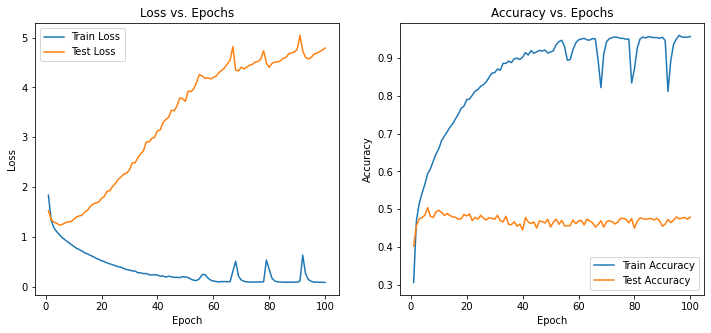

In [5]:
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 5))

# 绘制损失图像
plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss vs. Epochs')

# 绘制准确率图像
plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy vs. Epochs')

plt.show()


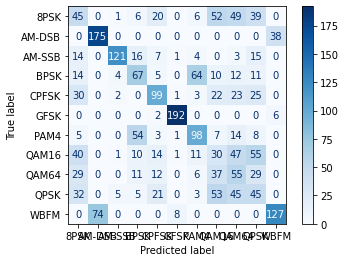

In [6]:
# 计算混淆矩阵
all_labels = []
all_predictions = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_labels.extend(labels.numpy())
        all_predictions.extend(predicted.numpy())

# 绘制混淆矩阵
cm = confusion_matrix(all_labels, all_predictions)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=data_frame['Mod_Type'].astype('category').cat.categories)
disp.plot(cmap=plt.cm.Blues)
plt.show()
